# Clustering Anomaly Detection

## Clustering - DBSCAN

### 1. Use DBSCAN to detect anomalies in other products from the customers dataset.



### Imports

In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")

In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


In [6]:
df.shape

(440, 8)

In [8]:
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [9]:
# df.drop(["Channel", "Region"], axis = 1, inplace = True)
df = df[['Frozen', 'Detergents_Paper', 'Delicassen']]

In [10]:
df.head()

,Frozen,Detergents_Paper,Delicassen
customer_id,,,
0,214,2674,1338
1,1762,3293,1776
2,2405,3516,7844
3,6404,507,1788
4,3915,1777,5185


In [11]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 214., 2674., 1338.],
       [1762., 3293., 1776.],
       [2405., 3516., 7844.],
       [6404.,  507., 1788.],
       [3915., 1777., 5185.],
       [ 666., 1795., 1451.],
       [ 480., 3140.,  545.],
       [1669., 3321., 2566.],
       [ 425., 1716.,  750.],
       [1159., 7425., 2098.]], dtype=float32)

In [12]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605233, 0.16355862],
       [0.1048419 , 0.01234568, 0.03723405],
       [0.063934  , 0.04345483, 0.10809346],
       [0.01053514, 0.04389575, 0.03020442],
       [0.00747814, 0.07684205, 0.0113058 ],
       [0.02701992, 0.08127572, 0.05346267],
       [0.00657419, 0.04196061, 0.01558198],
       [0.01863783, 0.18180482, 0.04370046]], dtype=float32)

In [13]:
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [14]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [15]:
#extract cluster labels
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
df['labels'] = labels
df.labels.value_counts()

 0    423
-1     17
Name: labels, dtype: int64

In [17]:
df[df.labels==-1].head()

,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen,labels
23,5154,4337,16523,0.084298,0.106163,0.344597,-1
47,7782,24171,6465,0.127490,0.592005,0.134793,-1
56,2616,17740,1340,0.042584,0.434475,0.027889,-1
61,3254,26701,2017,0.053070,0.653978,0.042011,-1
65,36,24231,1423,0.000181,0.593474,0.029620,-1


In [18]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
             Frozen  Detergents_Paper    Delicassen  Scaled_Frozen  \
count    440.000000        440.000000    440.000000     440.000000   
mean    3071.931818       2881.493182   1524.870455       0.050078   
std     4854.673333       4767.854448   2820.105937       0.079789   
min       25.000000          3.000000      3.000000       0.000000   
25%      742.250000        256.750000    408.250000       0.011788   
50%     1526.000000        816.500000    965.500000       0.024670   
75%     3554.250000       3922.000000   1820.250000       0.058005   
max    60869.000000      40827.000000  47943.000000       1.000000   

       Scaled_Detergents_Paper  Scaled_Delicassen      labels  
count               440.000000         440.000000  440.000000  
mean                  0.070510           0.031745   -0.038636  
std                   0.116790           0.058826    0.192946  
min                   0.000000           0.000000   -1.000000  
25%                   0.006216        

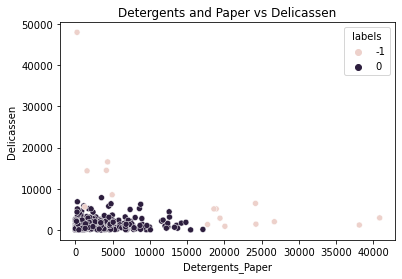

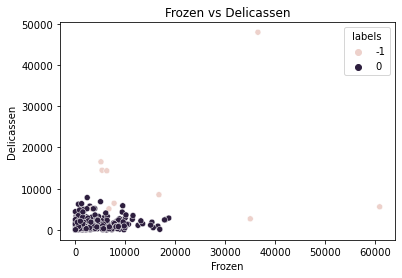

In [22]:
#scatterplots of frozen, Detergents_Paper, and Delicassen with labels as hue
sns.scatterplot(df.Detergents_Paper, df.Delicassen, hue=df.labels)
plt.title('Detergents and Paper vs Delicassen')
plt.show()

sns.scatterplot(df.Frozen, df.Delicassen, hue=df.labels)
plt.title('Frozen vs Delicassen')
plt.show()

Text(0.5, 0, 'Delicassen')

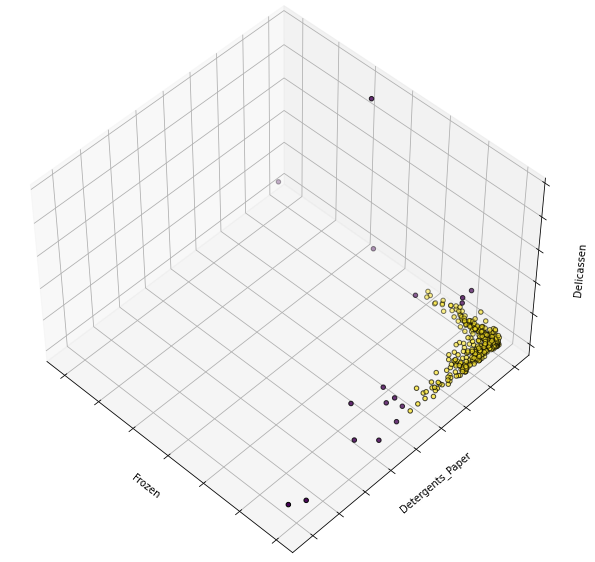

In [24]:
# 3d viz
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Frozen, df.Detergents_Paper, df.Delicassen,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
# 'Frozen', 'Detergents_Paper', 'Delicassen'
ax.set_xlabel('Frozen')
ax.set_ylabel('Detergents_Paper')
ax.set_zlabel('Delicassen')

### Experiment with the DBSCAN properties

* DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

* Read up on the epsilon and min_samples arguments into DBSCAN at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

#### 1. Experiment with altering the epsilon values (the eps argument holding the threshhold parameter). Run the models and visualize the results. What has changed? Why do you think that is?

<b>Parameters: </b>
<br> <b>eps: float, default=0.5 </b>
    <br> The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

- epsilon is a distance parameter
- epsilon is simply a distance that you set
- you can think of it like a radius froma datapoint that broadcasts out in all directions, forming a perimeter around that datapoint

In [29]:
X = df.values.astype("float32", copy = False)
eps = .10
min_samples = 20

def dbscan(X, eps, min_samples):
    mm = MinMaxScaler()
    X = mm.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='tab20')
    plt.title("DBSCAN")

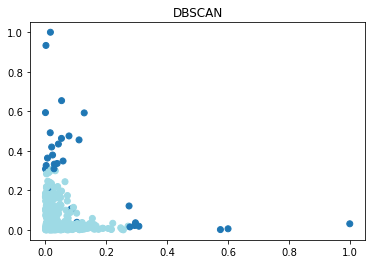

In [30]:
#eps = .10
eps = .10
dbscan(X, eps, min_samples)

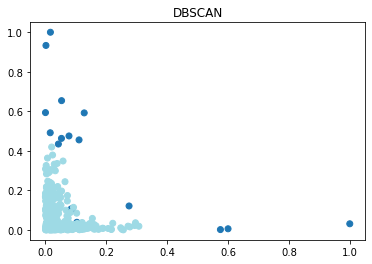

In [31]:
#eps = .20
eps = .20
dbscan(X, eps, min_samples)

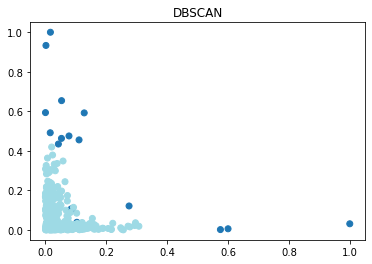

In [32]:
#eps = .30
eps = .30
dbscan(X, eps, min_samples)

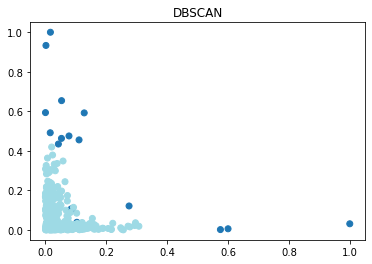

In [33]:
#eps = .40
eps = .40
dbscan(X, eps, min_samples)

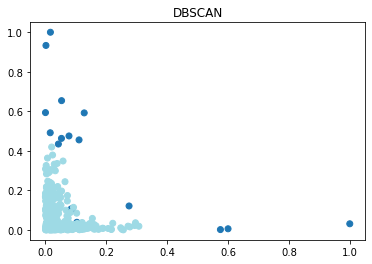

In [35]:
#eps = .90
eps = .90
dbscan(X, eps, min_samples)

#### 2. Double the min_samples parameter. Run your model and visualize the results. Consider what changed and why.

<br> <b>min_samples: int, default=5 </b>
    <br> The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

- minimum points is the minimum number of core points (including the starting point) that must exist for a cluster to be formed

In [36]:
X = df.values.astype("float32", copy = False)
eps = .10
min_samples = 20

def dbscan(X, eps, min_samples):
    mm = MinMaxScaler()
    X = mm.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='tab20')
    plt.title("DBSCAN")

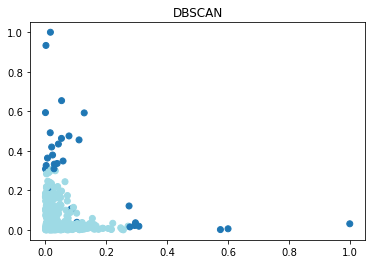

In [38]:
# min samples = 20
dbscan(X, eps, min_samples)

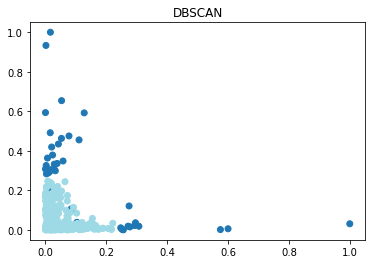

In [39]:
# min samples = 40
min_samples = 40
dbscan(X, eps, min_samples)

#### The minimum samples required to form a cluster increased from 20 core points to 40 core points.  With the minimum sample doubled, a cluster now can only form with 40 core points, which is why the dark blue points increased to include those 40 core points. 

### 2. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [91]:
def zillow17():
    '''
    This function reads in the zillow data from the Codeup db
    and returns a pandas DataFrame with:
    - all fields related to the properties that are available
    - using all the tables in the database
    - Only include properties with a transaction in 2017
    - include only the last transaction for each property
    - zestimate error
    - date of transaction
    - Only include properties that include a latitude and longitude value
    '''
    
    query = """
            SELECT prop.*,
                   pred.logerror,
                   pred.transactiondate,
                   air.airconditioningdesc,
                   arch.architecturalstyledesc,
                   build.buildingclassdesc,
                   heat.heatingorsystemdesc,
                   landuse.propertylandusedesc,
                   story.storydesc,
                   construct.typeconstructiondesc
            FROM   properties_2017 prop
            INNER JOIN (SELECT parcelid,
                               logerror,
                               Max(transactiondate) transactiondate
                        FROM   predictions_2017
                        GROUP  BY parcelid, logerror) pred
                     USING (parcelid)
            LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
            LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
            LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
            LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
            LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
            LEFT JOIN storytype story USING (storytypeid)
            LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
            WHERE prop.latitude IS NOT NULL
                  AND prop.longitude IS NOT NULL
                  AND transactiondate like '2017%%'
    """
    url = get_db_url("zillow")
    df = pd.read_sql(query, url)
    
    return df

In [92]:
    
def drop_based_on_pct(df, pc, pr):
    """
    drop_based_on_pct takes in: 
    - dataframe, 
    - threshold percent of non-null values for columns(# between 0-1), 
    - threshold percent of non-null values for rows(# between 0-1)
    Returns: a dataframe with the columns and rows dropped as indicated.
    """
    tpc = 1-pc
    tpr = 1-pr
    df.dropna(axis = 1, thresh = tpc * len(df.index), inplace = True)
    df.dropna(axis = 0, thresh = tpr * len(df.columns), inplace = True)
    return df
    
    


    
def outlier(df, feature, m):
    '''
    outlier will take in a dataframe's feature:
    - calculate it's 1st & 3rd quartiles,
    - use their difference to calculate the IQR
    - then apply to calculate upper and lower bounds
    - using the `m` multiplier
    '''
    q1 = df[feature].quantile(.25)
    q3 = df[feature].quantile(.75)
    
    iqr = q3 - q1
    
    multiplier = m
    upper_bound = q3 + (multiplier * iqr)
    lower_bound = q1 - (multiplier * iqr)
    
    return upper_bound, lower_bound




    
    
def clean_zillow(df):
    """
    clean_zillow will:
    - read in df acquired from SQL query
    - filter data to single unit homes with min 1B/1B over 500 sqft
    - drop columns with 40%+ & rows 30%+ null
    - add a column for county names
    - drop unnecessary columns
    - fills in unitcnt/lotsizesquarefeet/buildingqualitytypeid nulls
    - drops remaining nulls
    - removes extreme outliers for home_value & sqft
    - adds a home_age & log_quartiles column
    - converts certain float columns to int
    - renames certain columns
    """
    
    # Restrict df to only properties that meet single-use criteria
    single_use = [260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 273, 275, 276, 279]
    df = df[df.propertylandusetypeid.isin(single_use)]
    
    # Filter those properties without at least 1 bath & bed and 500 sqft area
    df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())\
            & (df.calculatedfinishedsquarefeet>500)]
    
    # Handle missing values i.e. drop columns and rows based on a threshold
    df = drop_based_on_pct(df, .6, .7)
    
    # Add column for counties
    df['county'] = np.where(df.fips == 6037, 'Los_Angeles',
                           np.where(df.fips == 6059, 'Orange',
                                   'Ventura'))
    
    # Drop unnecessary/redundant columns
    df = df.drop(['id', 'calculatedbathnbr', 'finishedsquarefeet12', 
                  'fullbathcnt', 'heatingorsystemtypeid', 
                  'propertycountylandusecode', 'propertylandusetypeid', 
                  'propertyzoningdesc', 'censustractandblock', 'propertylandusedesc', 
                  'heatingorsystemdesc', 'assessmentyear', 'regionidcounty' ],axis=1)
    
    
    # Replace nulls with median values for select columns
    df.lotsizesquarefeet.fillna(7265, inplace = True)
    df.buildingqualitytypeid.fillna(7.0, inplace = True)
    
    # Drop any remaining nulls
    df = df.dropna()
    
    # Columns that need to be adjusted for outliers
    df = df[df.taxvaluedollarcnt < 5_000_000]
    df = df[df.calculatedfinishedsquarefeet < 12500]
    
    # create column for age of home
    df['home_age'] = 2021 - df.yearbuilt
    
    # List of cols to convert to 'int'
    cols = ['fips', 'buildingqualitytypeid', 'bedroomcnt', 
            'home_age', 'yearbuilt']
    # loop through cols list in conversion
    for col in cols:
        df[col] = df[col].astype('int')
        
    # Rename columns
    df.rename(columns={"bathroomcnt": "bathrooms", 
                   "bedroomcnt": "bedrooms",
                   "buildingqualitytypeid": "property_quality", 
                   "calculatedfinishedsquarefeet": "sqft",
                   "lotsizesquarefeet": "lot_sqft",
                   "regionidzip": "zip_code",
                   "landtaxvaluedollarcnt": "land_value",
                   "structuretaxvaluedollarcnt": "structure_value",
                   "taxvaluedollarcnt": "home_value"
                  }, inplace=True)
    

    # create a categorical version of target by splitting into quartiles
    df['logerror_quartiles'] = pd.qcut(df.logerror, q=4, labels=['q1', 'q2', 'q3', 'q4'])
    
    # Drop unnecessary/redundant columns
    df = df.drop(['rawcensustractandblock', 'regionidcity', 'zip_code', 'roomcnt', 'unitcnt', 'transactiondate'],axis=1)
    
    return df

In [93]:
df = clean_zillow(zillow17())

In [94]:
df.head()

,parcelid,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,yearbuilt,structure_value,home_value,land_value,taxamount,logerror,county,home_age,logerror_quartiles
3,12177905,3.0,4,8,2376.0,6037,34245180.0,-118240722.0,13038.0,1970,108918.0,145143.0,36225.0,1777.51,-0.103410,Los_Angeles,51,q1
4,10887214,3.0,3,8,1312.0,6037,34185120.0,-118414640.0,278581.0,1964,73681.0,119407.0,45726.0,1533.89,0.006940,Los_Angeles,57,q3
6,12095076,3.0,4,9,2962.0,6037,34145202.0,-118179824.0,63000.0,1950,276684.0,773303.0,496619.0,9516.26,-0.001011,Los_Angeles,71,q2
7,12069064,1.0,2,5,738.0,6037,34149214.0,-118239357.0,4214.0,1922,18890.0,218552.0,199662.0,2366.08,0.101723,Los_Angeles,99,q4
8,12790562,3.0,4,9,3039.0,6037,33960230.0,-118006914.0,20028.0,1970,177527.0,220583.0,43056.0,3104.19,-0.040966,Los_Angeles,51,q1


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45788 entries, 3 to 77573
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   parcelid            45788 non-null  int64   
 1   bathrooms           45788 non-null  float64 
 2   bedrooms            45788 non-null  int64   
 3   property_quality    45788 non-null  int64   
 4   sqft                45788 non-null  float64 
 5   fips                45788 non-null  int64   
 6   latitude            45788 non-null  float64 
 7   longitude           45788 non-null  float64 
 8   lot_sqft            45788 non-null  float64 
 9   yearbuilt           45788 non-null  int64   
 10  structure_value     45788 non-null  float64 
 11  home_value          45788 non-null  float64 
 12  land_value          45788 non-null  float64 
 13  taxamount           45788 non-null  float64 
 14  logerror            45788 non-null  float64 
 15  county              45788 non-null  

In [96]:
df.shape

(45788, 18)

In [97]:
# select variables you want to cluster
df = df[["bedrooms", "sqft"]]

In [98]:
df.head()

,bedrooms,sqft
3,4,2376.0
4,3,1312.0
6,4,2962.0
7,2,738.0
8,4,3039.0


In [99]:
df.shape

(45788, 2)

In [100]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[4.000e+00, 2.376e+03],
       [3.000e+00, 1.312e+03],
       [4.000e+00, 2.962e+03],
       [2.000e+00, 7.380e+02],
       [4.000e+00, 3.039e+03],
       [2.000e+00, 1.290e+03],
       [4.000e+00, 2.540e+03],
       [3.000e+00, 1.435e+03],
       [2.000e+00, 1.146e+03],
       [3.000e+00, 1.092e+03]], dtype=float32)

In [101]:
np_array.shape

(45788, 2)

In [102]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.3       , 0.1625065 ],
       [0.20000002, 0.07028948],
       [0.3       , 0.2132952 ],
       [0.1       , 0.02054082],
       [0.3       , 0.21996878],
       [0.1       , 0.06838274],
       [0.3       , 0.1767204 ],
       [0.20000002, 0.0809499 ],
       [0.1       , 0.05590223],
       [0.20000002, 0.05122204]], dtype=float32)

In [103]:
#Construct a DBSCAN object that requires a minimum of 15 data points in a neighborhood 
#of radius 0.5 to be considered a core point.
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)


In [104]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]



In [105]:
scaled_columns

['Scaled_bedrooms', 'Scaled_sqft']

In [106]:
# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [107]:
original_df.shape

(45788, 2)

In [108]:
original_df.head()

,bedrooms,sqft
3,4,2376.0
4,3,1312.0
6,4,2962.0
7,2,738.0
8,4,3039.0


In [109]:
scaled_df.shape

(45788, 2)

In [110]:
scaled_df.head()

,Scaled_bedrooms,Scaled_sqft
0,0.3,0.162507
1,0.2,0.070289
2,0.3,0.213295
3,0.1,0.020541
4,0.3,0.219969


In [111]:
df.shape

(45788, 4)

In [112]:
df.tail()

,bedrooms,sqft,Scaled_bedrooms,Scaled_sqft
45783,4,1633.0,0.3,0.098111
45784,3,1741.0,0.2,0.107471
45785,2,1286.0,0.1,0.068036
45786,3,1032.0,0.2,0.046022
45787,3,1762.0,0.2,0.109291


In [113]:
# Next, we can extract our cluster labels and outliers to plot our results.
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [114]:
df['labels'] = labels
df.labels.value_counts()

 0    30885
 1    12719
 2     2140
-1       44
Name: labels, dtype: int64

In [115]:
df[df.labels==-1].head()


,bedrooms,sqft,Scaled_bedrooms,Scaled_sqft,labels
267,8,8837.0,0.7,0.722482,-1
1269,5,9848.0,0.4,0.810106,-1
1359,8,3247.0,0.7,0.237996,-1
1565,6,10686.0,0.5,0.882735,-1
1989,7,8391.0,0.6,0.683827,-1


In [116]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
           bedrooms          sqft  Scaled_bedrooms   Scaled_sqft        labels
count  45788.000000  45788.000000     45788.000000  45788.000000  45788.000000
mean       2.952913   1674.996396         0.195318      0.101750      0.370294
std        0.976770    839.503694         0.097682      0.072760      0.573219
min        1.000000    501.000000         0.000000      0.000000     -1.000000
25%        2.000000   1140.000000         0.100000      0.055382      0.000000
50%        3.000000   1465.000000         0.200000      0.083550      0.000000
75%        4.000000   1953.000000         0.300000      0.125845      1.000000
max       11.000000  12039.000000         1.000000      1.000000      2.000000
-------------
Inliers
           bedrooms          sqft  Scaled_bedrooms   Scaled_sqft   labels
count  30885.000000  30885.000000     30885.000000  30885.000000  30885.0
mean       3.474955   1921.113194         0.247513      0.123081      0.0
std        0.690047    850.577710 

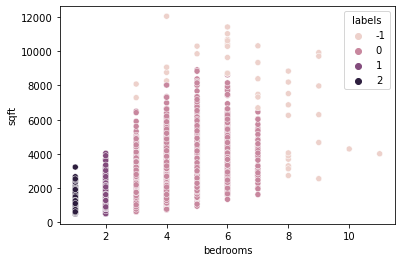

In [117]:
#scatterplots
sns.scatterplot(df.bedrooms, df.sqft, hue=df.labels)
plt.show()


Text(0.5, 0, 'sqft')

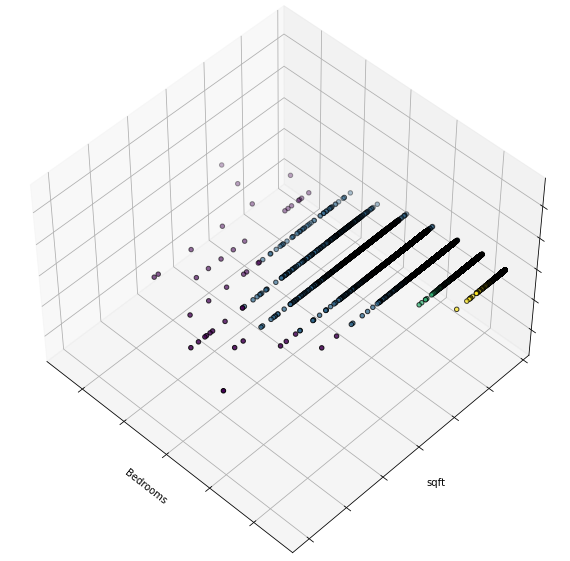

In [119]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.bedrooms, df.sqft,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Bedrooms')
ax.set_ylabel('sqft')


In [120]:
import wrangle as w

In [121]:
df = w.prepare_logs()

In [122]:
df.head()

,name,program_id,cohort_id,user_id,path,ip,start_date,end_date,day_of_week,month
2018-01-26 09:55:03,Hampton,full stack php,8.0,1,/,97.105.19.61,2015-09-22,2016-02-06,Friday,January
2018-01-26 09:56:02,Hampton,full stack php,8.0,1,java-ii,97.105.19.61,2015-09-22,2016-02-06,Friday,January
2018-01-26 09:56:05,Hampton,full stack php,8.0,1,java-ii/object-oriented-programming,97.105.19.61,2015-09-22,2016-02-06,Friday,January
2018-01-26 09:56:06,Hampton,full stack php,8.0,1,slides/object_oriented_programming,97.105.19.61,2015-09-22,2016-02-06,Friday,January
2018-01-26 09:56:24,Teddy,full stack java,22.0,2,javascript-i/conditionals,97.105.19.61,2018-01-08,2018-05-17,Friday,January


In [123]:
# Cluster on all or a selected subset of features
program_cohort = df[['program_id', 'cohort_id']]
program_cohort.head()

,program_id,cohort_id
2018-01-26 09:55:03,full stack php,8.0
2018-01-26 09:56:02,full stack php,8.0
2018-01-26 09:56:05,full stack php,8.0
2018-01-26 09:56:06,full stack php,8.0
2018-01-26 09:56:24,full stack java,22.0
